# Prepare Data
Notebook dedicado a extraer datos de simulación y organizarlos en pd.DataFrames y estudiar la correlación de las features de entrenamiento

### ! NOTA: Este notebook fue inicialmente creado para extraer eventos de neutrinos solares y eventos ed Talio en la misma proporción, ahora seran retirado unicamente evetos de neutrinos solares, por ahora, para equilibriar el espectro a altas energias

In [1]:
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn
import pandas as pd 

from sklearn.preprocessing import RobustScaler, normalize

In [2]:
def magnitude(vector): 
    #Funcion para calcular radio de eventos al centro del detector
    
    norm = []
    for vec in vector:
    	norm.append(np.linalg.norm(vec))

    return np.array(norm, dtype = np.float32)

# 1 - Extraer datos

In [3]:
# Archivo de Neutrinos Solares
solar_file = uproot.open("/snoplus simulations/solar_nu/High Stat/split_3_simu_Analysis_solar_Nue.root")  
solar_file.keys()

['T;61', 'T;60', 'pmt;2', 'pmt;1']

In [4]:
solar_data = solar_file['T;61']
pmt_info = solar_file['pmt;1']

## 1.1 - PMT info

In [5]:
pmt_id = np.array(pmt_info['pmt_id'], dtype = np.int16)
pmt_pos_xyz = np.array(pmt_info['pmt_pos_xyz'])
pmt_pos_sph = np.array(pmt_info['pmt_pos_sph'])
pmt_type = np.array(pmt_info['pmt_type'], dtype = np.int16)

## 1.2 - Solar Variables

In [6]:
solar_data.keys()

['evtid',
 'mcID',
 'energy',
 'mc_position',
 'mc_momentum',
 'position',
 'momentum',
 'hit_pmtid',
 'hit_pmttime',
 'hit_residual',
 'hit_type']

In [7]:
solar_mcID = np.array(solar_data['mcID'], dtype = np.int16)#[:solar_limit]
solar_energy = np.array(solar_data['energy'], dtype = np.float32)#[:solar_limit]
solar_mc_position = np.array(solar_data['mc_position'])#[:solar_limit]   #-> Position Generation
solar_mc_momentum = np.array(solar_data['mc_momentum'])#[:solar_limit]   #-> IMPORTANT: Direction of simulated event
solar_position = np.array(solar_data['position'])#[:solar_limit]        
solar_hit_pmtid = np.array(solar_data['hit_pmtid'], dtype = np.int16)#[:solar_limit]
solar_time_residual = np.array(solar_data['hit_residual'])#[:solar_limit]
solar_hit_type = np.array(solar_data['hit_type'], dtype = np.int16)#[:solar_limit]

## 1.3 - Numero de Eventos de Simulación

### 1.3.1 - Nº solar_nu

In [8]:
solar_break_i = [0]

solar_N_data = len(solar_mcID)

for solar_i in range(solar_N_data-1):
    if solar_mcID[solar_i] != solar_mcID[solar_i+1]:
        solar_break_i.append(solar_i+1)

solar_break_i = np.array(solar_break_i)

N_solar_evs = len(solar_break_i)

print('Solar events:', N_solar_evs)

Solar events: 142427


### * (Espectro de Energia de Simulación) Cortes de Calidad (volumen)

In [9]:
#Extract unique Data
uni_solar_en = []
uni_solar_pos = []

uni_tl_en = []
uni_tl_pos = []

for i in solar_break_i:
    uni_solar_en.append(solar_energy[i])
    uni_solar_pos.append(solar_position[i])
    
for j in tl_break_i:
    uni_tl_en.append(tl_energy[j])
    uni_tl_pos.append(tl_position[j])


uni_solar_en = np.array(uni_solar_en)
uni_solar_pos = np.array(uni_solar_pos)
uni_solar_rad = magnitude(uni_solar_pos)

uni_tl_en = np.array(uni_tl_en)
uni_tl_pos = np.array(uni_tl_pos)
uni_tl_rad = magnitude(uni_tl_pos)

#Cuts (energy and volume)
min_energy = 0.5
max_rad = 5500.0

uni_solar_en_cut = []
uni_solar_rad_cut = []

uni_tl_en_cut = []
uni_tl_rad_cut = []

for i in np.where((uni_solar_rad < max_rad) & (uni_solar_en > min_energy))[0]:
    uni_solar_en_cut.append(uni_solar_en[i])
    uni_solar_rad_cut.append(uni_solar_rad[i])

for j in np.where((uni_tl_rad < max_rad) & (uni_tl_en > min_energy))[0]:
    uni_tl_en_cut.append(uni_tl_en[j])
    uni_tl_rad_cut.append(uni_tl_rad[j])

uni_solar_en_cut = np.array(uni_solar_en_cut)
uni_solar_rad_cut = np.array(uni_solar_rad_cut)

uni_tl_en_cut = np.array(uni_tl_en_cut)
uni_tl_rad_cut = np.array(uni_tl_rad_cut)

all_energy = np.concatenate((uni_solar_en_cut, uni_tl_en_cut))

NameError: name 'tl_break_i' is not defined

In [38]:
len(uni_solar_en)

302209

In [39]:
len(uni_tl_en)

159817

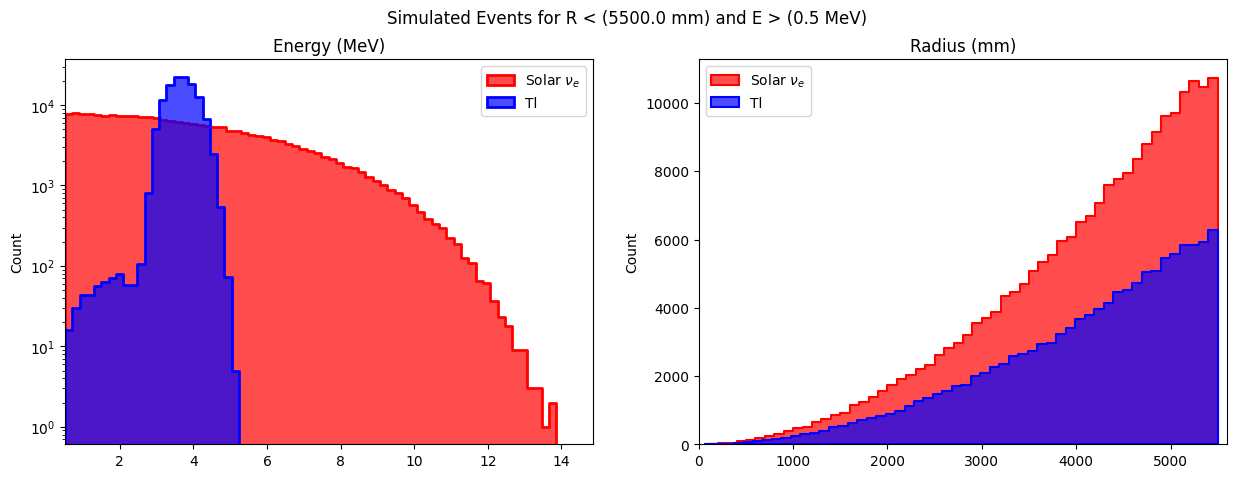

In [40]:
binwidth_en = 0.2
alpha_en = 0.7
linewidth_en = 2

binwidth_rad = 100
alpha_rad = 0.7
linewidth_rad = 1.5

figure, axes = plt.subplots(1,2, figsize=(15, 5))

sn.histplot(uni_solar_en_cut, binwidth = binwidth_en, color = 'r', label = 'Solar $ν_e$', common_bins = True, 
            alpha = alpha_en, linewidth = linewidth_en, element = 'step', kde=False, ax = axes[0])
sn.histplot(uni_tl_en_cut, binwidth = binwidth_en, color = 'b', label = 'Tl', common_bins = True, 
            alpha = alpha_en, linewidth = linewidth_en, element = 'step', kde=False, ax = axes[0])

sn.histplot(uni_solar_rad_cut, binwidth = binwidth_rad, color = 'r', label = 'Solar $ν_e$', common_bins = True, 
            alpha = alpha_rad, linewidth = linewidth_rad, element = 'step', kde=False, ax = axes[1])
sn.histplot(uni_tl_rad_cut, binwidth = binwidth_rad, color = 'b', label = 'Tl', common_bins = True, 
            alpha = alpha_rad, linewidth = linewidth_rad, element = 'step', kde=False, ax = axes[1])


axes[0].set_title('Energy (MeV)')
axes[1].set_title('Radius (mm)')

axes[0].legend()
axes[1].legend(loc = 'upper left')

axes[0].set_yscale('log')

axes[0].set_xlim(np.min(all_energy), np.max(all_energy) + 1)
axes[1].set_xlim(0,5600)

plt.suptitle('Simulated Events for R < ('+str(max_rad)+' mm) and E > ('+str(min_energy)+' MeV)')
#plt.savefig('figs/First Model/10x10/Data/simulated_data_(E,R).png', format = 'png', bbox_inches = 'tight')

# 2 - Select Valid Data

Select only hits that verify pmt_type = 1

In [9]:
valid_pmt_id = np.array(np.where(pmt_type == 1)[0]) # PMT valid ID match with index where pmt_type=1

#extract valid indices in data
solar_valid_id_info_i = np.array(np.where(np.in1d(solar_hit_pmtid, valid_pmt_id))[0])

#extract coordinates of pmt_type = 1
valid_pmt_xyz = []   #List of valid PMT coordinates (type 1)
for i_dx in valid_pmt_id:
    valid_pmt_xyz.append(pmt_pos_xyz[i_dx])
valid_pmt_xyz = np.array(valid_pmt_xyz)

In [13]:
solar_valid_id_info_i

array([        0,         1,         2, ..., 101582484, 101582485,
       101582486], dtype=int64)

# 3 - Process Data

Procesamiento de datos (corte en volumen, energia y tiempo), calculo de observable cos(α)

## 3.1 - Ajuste de Procesamiento

El ajuste será aplicado a simulaciones de Tálio y de neutrinos Solares

In [10]:
#params to adjust the cuts--------------------------------------------
#Split Data
split = 20

#energy cut
inf_en_cut = 2.5
up_en_cut = 14

#time cut (ns)
inf_cut = -5.0
up_cut = 7.0

#radial cut
radi_cut_method = True   #If true, apply radial cuts given by rad_cut_val to data
rad_cut_val = 5500.0   # Buen valor de corte para observar una identificación efizas de neutrinos solares
#--------------------------------------------------------------------------

### 3.1.1 - Procesamiento de Solares

In [11]:
# Dividir valid_id_info_ev_i en partes
valid_info_ev_split = np.array_split(solar_valid_id_info_i, split)  #---> split(array, parts)

#variables to save: with time residual cuts and radi cut (radi cut is optional, depends on the simulation)
solar_multi_time_residual_cut = []
solar_multi_cos_angle_cut = []
#multi_position_cut = []
solar_multi_mc_momentum_cut = []
solar_multi_mc_ID_cut = []
solar_multi_energy_cut = []
solar_multi_radi_cut = []

#loop over valid_info_ev_split
for n_loop, split_array in enumerate(valid_info_ev_split):
    print('slipt nº:', n_loop)
    # extract all valid simulated info 
    multi_radi = []
    multi_energy = []
    multi_mc_ID = []
    multi_time_residual = []
    multi_pmt_id_hit = []
    multi_position = []
    #multi_mc_position = []
    multi_mc_momentum = []   
    multi_xyz_hit = []

    for valid_i in split_array:
        multi_energy.append(solar_energy[valid_i])
        multi_mc_ID.append(solar_mcID[valid_i])
        multi_time_residual.append(solar_time_residual[valid_i])
        multi_pmt_id_hit.append(solar_hit_pmtid[valid_i])
        multi_position.append(solar_position[valid_i])
        #multi_mc_position.append(mc_position[valid_i])
        multi_mc_momentum.append(solar_mc_momentum[valid_i])
    multi_energy = np.array(multi_energy)
    multi_time_residual = np.array(multi_time_residual)
    multi_pmt_id_hit = np.array(multi_pmt_id_hit)
    multi_position = np.array(multi_position)

    for id_i in multi_pmt_id_hit:
        multi_xyz_hit.append(pmt_pos_xyz[id_i])
    multi_xyz_hit = np.array(multi_xyz_hit)

    #energy_cut:
    print('In energy cut')
    condition_en_cut = (multi_energy > inf_en_cut) & (multi_energy < up_en_cut)
    
    #variables to extract
    multi_energy = np.extract(condition_en_cut, multi_energy)
    multi_mc_ID = np.extract(condition_en_cut, multi_mc_ID)
    multi_time_residual = np.extract(condition_en_cut, multi_time_residual)
    multi_pmt_id_hit = np.extract(condition_en_cut, multi_pmt_id_hit)

    multi_mc_momentum_en_cut = []
    multi_position_en_cut = []
    for e_dx in np.where(condition_en_cut)[0]:
        multi_mc_momentum_en_cut.append(multi_mc_momentum[e_dx])
        multi_position_en_cut.append(multi_position[e_dx])
    multi_mc_momentum = np.array(multi_mc_momentum_en_cut)
    multi_position = np.array(multi_position_en_cut)
    #freed memory
    multi_mc_momentum_en_cut = None
    multi_position_en_cut = None
            
    #Radial Cut:
    if radi_cut_method == True:
        print('In radi_cut')
        #mc_position_norm = magnitude(multi_mc_position)
        position_norm = magnitude(multi_position)
        multi_radi.append(position_norm)
        
        max_radi = rad_cut_val
        radi_condition = (position_norm < max_radi)
        index_cut_radi = np.array(np.where(radi_condition)[0])
        #variables to extract
        multi_time_residual = np.extract(radi_condition, multi_time_residual)
        multi_pmt_id_hit = np.extract(radi_condition, multi_pmt_id_hit)
        multi_energy = np.extract(radi_condition, multi_energy)
        multi_radi = np.extract(radi_condition, multi_radi)

        multi_mc_ID_radi_cut = []
        multi_mc_momentum_radi_cut = []
        multi_position_radi_cut = []
        multi_xyz_hit_radi_cut = [] 

        for j_dx in index_cut_radi:
            multi_mc_momentum_radi_cut.append(multi_mc_momentum[j_dx])
            multi_position_radi_cut.append(multi_position[j_dx])          #HERE
            multi_mc_ID_radi_cut.append(multi_mc_ID[j_dx])

        for id_i in multi_pmt_id_hit:
            multi_xyz_hit_radi_cut.append(pmt_pos_xyz[id_i])

        multi_mc_ID = multi_mc_ID_radi_cut
        multi_mc_momentum = multi_mc_momentum_radi_cut   #HERE
        multi_position = multi_position_radi_cut
        multi_xyz_hit = multi_xyz_hit_radi_cut
        
        #freed memory
        multi_mc_ID_radi_cut = None
        multi_mc_momentum_radi_cut = None
        multi_position_radi_cut = None
        multi_xyz_hit_radi_cut = None
        radi_condition = None
        index_cut_radi = None
        
    #cos(alpha) calculation -> Uses the definition of scalar product
    multi_cos_angle = []
    N = np.shape(multi_xyz_hit)[0]

    print('computing cos(alpha)')
    for k in range(N):
        #event_direction = np.array([0,0,-1])
        event_direction = multi_mc_momentum[k]
        scalar_product = np.dot(multi_xyz_hit[k], event_direction)
        norm_1 = np.linalg.norm(event_direction)
        norm_2 = np.linalg.norm(multi_xyz_hit[k])
        cos_val = scalar_product/(norm_1*norm_2)
        
        multi_cos_angle.append(cos_val)

    #Time residual cut:
    print('doing time residual cuts')
    for i in np.where((multi_time_residual > inf_cut) & (multi_time_residual < up_cut))[0]:
        solar_multi_time_residual_cut.append(multi_time_residual[i])
        solar_multi_cos_angle_cut.append(multi_cos_angle[i])
        #solar_multi_position_cut.append(multi_position[i])
        solar_multi_mc_momentum_cut.append(multi_mc_momentum[i])
        solar_multi_mc_ID_cut.append(multi_mc_ID[i])
        solar_multi_energy_cut.append(multi_energy[i])
        solar_multi_radi_cut.append(multi_radi[i])

    #freed memory
    multi_cos_angle = None

    #freen memory:    
    multi_mc_ID = None
    multi_time_residual = None
    multi_pmt_id_hit = None
    multi_position = None
    multi_mc_position = None
    multi_mc_momentum = None
    multi_xyz_hit = None
    multi_energy = None
    multi_radi = None

#multi_position_cut = np.array(multi_position_cut)
solar_multi_mc_momentum_cut = np.array(solar_multi_mc_momentum_cut)
solar_multi_mc_ID_cut = np.array(solar_multi_mc_ID_cut, dtype = np.int16)
solar_multi_energy_cut = np.array(solar_multi_energy_cut)
solar_multi_radi_cut = np.array(solar_multi_radi_cut)

slipt nº: 0
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 1
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 2
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 3
In energy cut
In radi_cut


KeyboardInterrupt: 

# 4 - Extraer Datos de Entrenamiento

Serán extraidos, evento a evento, las imagenes de la distribucion Δα y se hará la correspondencia de un label solar νe = 1)

In [12]:
solar_break_i = [0]

solar_N_data = len(solar_multi_mc_ID_cut)

for solar_i in range(solar_N_data-1):
    if solar_multi_mc_ID_cut[solar_i] != solar_multi_mc_ID_cut[solar_i+1]:
        solar_break_i.append(solar_i+1)

N_solar_evs = len(solar_break_i)

print('Nº Solar Events: despues de corte ', N_solar_evs)

Nº Solar Events: despues de corte  161026


## 4.1 - Extraer Datos para Solar $ν_e$

In [13]:
bins = 10

H_flaten_nu = []  #flatten images of solar nu evs
labels_nu = []  #save label of solar nu evs (1)
energy_nu = []
radi_nu = []

N_terms = len(solar_break_i)

for nu_i in range(N_terms - 1):
    init_nu = solar_break_i[nu_i]
    final_nu = solar_break_i[nu_i + 1]

    solar_time_res_ev = solar_multi_time_residual_cut[init_nu: final_nu]
    solar_cos_ev = solar_multi_cos_angle_cut[init_nu: final_nu]
    solar_energy_ev = solar_multi_energy_cut[init_nu]
    solar_radi_ev = solar_multi_radi_cut[init_nu]

    #COLOCAR AQUI ABAJO CORTE DE CALIDAD CASO SEA NECESARION (Nº DE REGOISTROS, ETC...)

    #raw histogram
    H_nu_ev, _, _ = np.histogram2d(x = solar_cos_ev, y =  solar_time_res_ev, bins = [bins, bins])

    #normalization by NHits
    sum_hit_nu_ev = np.sum(H_nu_ev,axis=0)
    H_nu_ev_norm = H_nu_ev/sum_hit_nu_ev
    H_nu_ev_norm = np.nan_to_num(H_nu_ev_norm, nan = 0.0)

    H_flatten_ev = H_nu_ev_norm.ravel()
    H_flaten_nu.append(H_flatten_ev)
    labels_nu.append(np.ones(len(H_flatten_ev), dtype = np.int8))
    energy_nu.append(np.ones(len(H_flatten_ev))*solar_energy_ev)
    radi_nu.append(np.ones(len(H_flatten_ev))*solar_radi_ev)

H_flaten_nu = np.array(H_flaten_nu).ravel()
labels_nu = np.array(labels_nu).ravel()
energy_nu = np.array(energy_nu).ravel()
radi_nu = np.array(radi_nu).ravel()

#Extraer imagenes Normalizadas y hacer flaten de los datos. 

C:\Users\joanc\AppData\Local\Temp\ipykernel_4656\3100496135.py:26: RuntimeWarning: invalid value encountered in divide
  H_nu_ev_norm = H_nu_ev/sum_hit_nu_ev


# 5 - Organizar los Datos:

Crear un PandasDataFrame que guarde los pixeles y su Label. Guardar DataFrame como archivo csv

In [14]:
all_pixels = H_flaten_nu
all_labels = labels_nu
all_energy = energy_nu
all_radi = radi_nu

data = {'pixel value': all_pixels,
       'labels': all_labels,
        'energy (MeV)': all_energy,
        'event radius (mm)': all_radi,
        }

df = pd.DataFrame(data)
df

,pixel value,labels,energy (MeV),event radius (mm)
0,0.000000,1,5.922100,5053.448242
1,0.000000,1,5.922100,5053.448242
2,0.055556,1,5.922100,5053.448242
3,0.192308,1,5.922100,5053.448242
4,0.058824,1,5.922100,5053.448242
...,...,...,...,...
16102495,0.604651,1,6.668801,4756.330566
16102496,0.566038,1,6.668801,4756.330566
16102497,0.511111,1,6.668801,4756.330566
16102498,0.396552,1,6.668801,4756.330566


In [19]:
df.to_csv("Data/High Stat/OnlySolarDF/df_solar3_5500_10_(2.5_14)_(-5_7).csv")

# 6 - Observar y Representar Datos

In [17]:
df_read = pd.read_csv("Data/High Stat/OnlySolarDF/df_solar3_5500_10_(2.5_14)_(-5_7).csv").drop(columns = ['Unnamed: 0'])

In [18]:
df_read

,pixel value,labels,energy (MeV),event radius (mm)
0,0.000000,1,5.922100,5053.448242
1,0.000000,1,5.922100,5053.448242
2,0.055556,1,5.922100,5053.448242
3,0.192308,1,5.922100,5053.448242
4,0.058824,1,5.922100,5053.448242
...,...,...,...,...
16102495,0.604651,1,6.668801,4756.330566
16102496,0.566038,1,6.668801,4756.330566
16102497,0.511111,1,6.668801,4756.330566
16102498,0.396552,1,6.668801,4756.330566


In [22]:
df_read.describe()

,pixel value,labels,energy (MeV),event radius (mm)
count,5.225100e+06,5225100.0,5.225100e+06,5.225100e+06
mean,9.808597e-02,1.0,5.150071e+00,4.100877e+03
std,1.358340e-01,0.0,1.951896e+00,1.070668e+03
min,0.000000e+00,1.0,2.500030e+00,1.061544e+02
25%,0.000000e+00,1.0,3.546517e+00,3.420602e+03
50%,5.882353e-02,1.0,4.785972e+00,4.340379e+03
75%,1.428571e-01,1.0,6.417796e+00,4.979320e+03
max,1.000000e+00,1.0,1.368808e+01,5.499972e+03


<Axes: xlabel='event radius (mm)', ylabel='Count'>

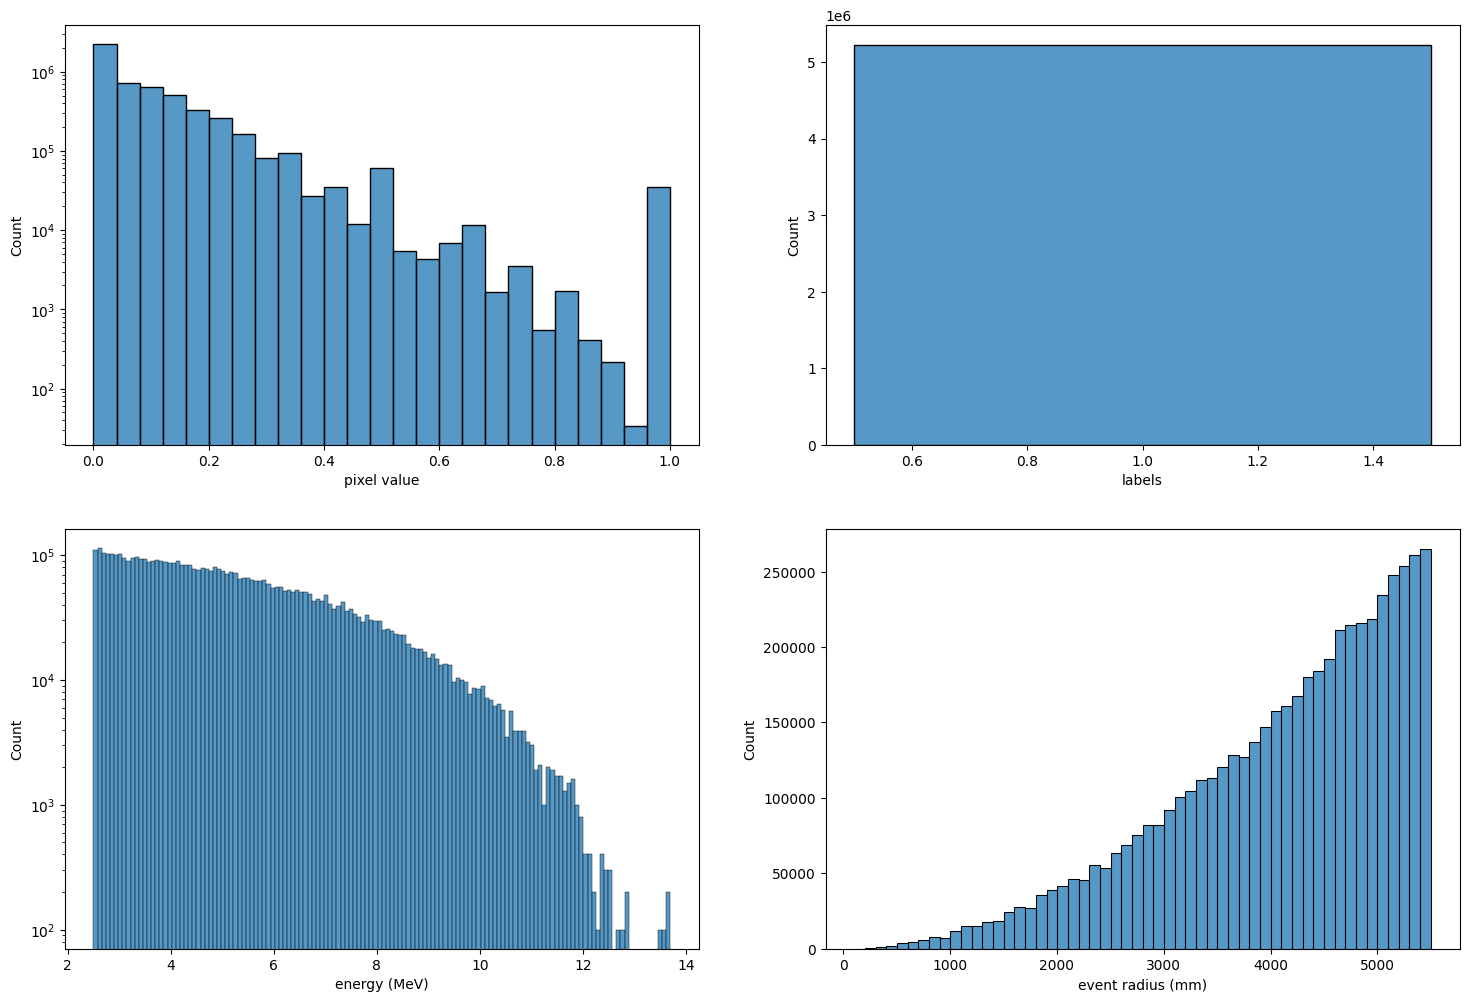

In [23]:
fig, axes = plt.subplots(2, 2,  figsize=(18, 12))

sn.histplot(data = df_read['pixel value'] , bins = 25, log = True, ax=axes[0,0])
sn.histplot(data = df_read['energy (MeV)'] , binwidth = 0.08, log = True ,ax=axes[1,0])
sn.histplot(data = df_read['labels'], ax=axes[0,1])
sn.histplot(data = df_read['event radius (mm)'], binwidth = 100 ,ax=axes[1,1])
#plt.savefig('figs/First Model/10x10/Data/data_set_representation.png', format = 'png', bbox_inches = 'tight')